# Реализация автоматического дифференцирования.

## Небольшое введение.

Tensorflow позволяет проводить вычисления посредством графа.
В математике существуют графы специального вида – графы вычислений, с помощью которых можно эффективно делать расчеты для заданных математических выражений.

Представьте, что у нас есть функция вида: 
$$f(x, y) = (x + y)^2 + 2xy$$
и мы хотим посчитать ее значения при разных x, y. Один из способов сделать это как раз через граф вычислений:
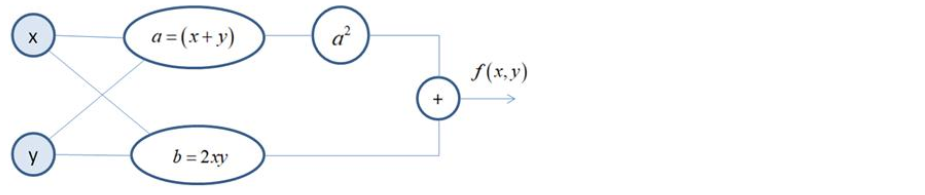

Эффективность здесь достигается за счет устранения дублирования при вычислениях (если они возникают), а также за счет распараллеливания независимых операций. Кроме того, как мы сейчас увидим, такой граф также позволяет эффективно вычислять и производные функции, что весьма полезно при разработке алгоритмов машинного обучения и, вообще, при решении различных оптимизационных задач.

Общая идея вычислительного графа – представить целевую функцию набором элементарных математических операций (сложение, вычитание, умножение, деление) и стандартного набора функций (sin, cos, exp, log, sqrt и т.д.). Существует теорема, доказывающая, что любую непрерывную функцию можно представить с заданной точностью набором таких математических действий, то есть, с помощью вычислительного графа.

## Вычисление производных.

Посмотрим, как эта конструкция позволяет вычислять производные. Возьмем граф для функции:
$$f(x, y) = (x + y)^2 + 2xy$$
и рассмотрим идею расчета производных, которая положена в основу Tensorflow. Мы будем искать численные значения производных, а не их аналитический вид. То есть, Tensorflow выполняет численное дифференцирование функций, используя для этого метод обратного вычисления производных (reverse mode differentiation).

Вначале нам нужно значениям x, y присвоить некоторые значения, для которых и будут вычисляться частные производные. Пусть, $x = 2, y = -4$. Пропускаем эти значения по графу и запоминаем результаты вычислений в каждом узле.

Затем, Tensorflow приступает к вычислению частных производных сложной функции $f(x, y)$ , используя цепное правило. В нашем примере оно реализуется, следующим образом:
$$
\frac{\partial f}{\partial x}=\frac{\partial f}{\partial a} \cdot \frac{\partial a}{\partial x}+\frac{\partial f}{\partial b} \cdot \frac{\partial b}{\partial x} \\
\frac{\partial f}{\partial y}=\frac{\partial f}{\partial a} \cdot \frac{\partial a}{\partial y}+\frac{\partial f}{\partial b} \cdot \frac{\partial b}{\partial y}$$ 
, где
$$
a=(x+y) \\
b=2 x y \\
f(x, y)=a^2+b
$$

Процесс вычисления производных начинается с конца (истока), то есть вычисляется производная $\frac{df}{df} = 1$. Далее, в соответствии с цепным правилом, нам нужно вычислить производную: $$\frac{df}{da} = \frac{d(a^2 + b)}{d(a)} = \frac{da^2}{da} = 2a$$

Так как функциональные узлы вычислительного графа составлены из элементарных функций, то Tensorflow «знает» аналитический вид их производных. И, в частности, «понимает», что $\frac{df}{da} = 2a$. Само значение $a = -2$ у нас было вычислено при прямом проходе по графу с $x = 2, y = -4$. Значит, 
$$\frac{df}{da} = 2a = 2(-2) =  -4$$

Далее, по цепному правилу нам нужно вычислить частную производную
$$
\frac{da}{dx} = \frac{d(x + y)}{dx} = \frac{dx}{dx} = 1
$$
, поэтому $\frac{\partial f}{\partial a} \cdot \frac{\partial a}{\partial x}=-4 \cdot 1=-4$. Аналогично сразу вычисляем и производную $\frac{\partial f}{\partial a} \cdot \frac{\partial a}{\partial y} = -4$.

Следующим шагом нам нужно вычислить производную:
$$
\frac{\partial f}{\partial b}=\frac{\partial\left(a^2+b\right)}{\partial b}=\frac{\partial b}{\partial b}=1
$$
И, затем, на основе частных производных $\frac{\partial b}{\partial x}=2 y ; \frac{\partial b}{\partial y}=2 x$ вычислить их при $х=2, y=-4$ :
$$
\frac{\partial b}{\partial x}=2 \cdot(-4)=-8 ; \frac{\partial b}{\partial y}=2 \cdot 2=4
$$
Складываем полученные величины и получаем частные производные функции по х и у:
$$
\begin{aligned}
&\frac{\partial f}{\partial x}=-4-8=-12 \\
&\frac{\partial f}{\partial y}=-4+4=0
\end{aligned}
$$

Вот так, с помощью вычислительного графа, мы нашли значения производных функции  в точке $x = 2, y = -4$. Аналогичным образом находит значения производных и Tensorflow.


In [18]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

x = tf.Variable(-2.0)

with tf.GradientTape() as tape: #GradientTape "запоминает" промежуточные вычисления для функции y = x^2
    y = x ** 2
    
df = tape.gradient(y, x)
print(df, end = '\n\n')

tf.Tensor(-4.0, shape=(), dtype=float32)



Для примера использования многомерного автоматического дифференцирования, рассмотрим следующий пример.

Пусть $y = \overline{x}^T \overline{\omega} + \overline{b}^T$, где $\overline{\omega}$ и $\overline{b}$ вектор-параметры. 
Определим функцию $loss = \frac{1}{N}\sum\limits^{N}_{i = 1} y_i^2$. Для нее и будем искать производные.

In [19]:
w = tf.Variable(tf.random.normal((3, 2)))
b = tf.Variable(tf.ones(2, dtype = tf.float32))
x = tf.Variable([[-2.0, 1.0, 3.0]])

#print(w,b,x,sep='\n\n')

with tf.GradientTape() as tape: #GradientTape "запоминает" промежуточные вычисления для функции y = x^2
    y = x @ w + b
    loss = tf.reduce_mean(y ** 2)
    
df = tape.gradient(loss, [w, b])
print(df[0], df[1], sep = '\n\n', end = '\n\n')

tf.Tensor(
[[-19.346825    6.634943 ]
 [  9.673412   -3.3174715]
 [ 29.020237   -9.9524145]], shape=(3, 2), dtype=float32)

tf.Tensor([ 9.673412  -3.3174715], shape=(2,), dtype=float32)



Как объект GradientTape() «узнает», какие промежуточные вычисления ему нужно отслеживать и сохранять в переменной tape? В Tensorflow это сделано относительно просто. Если функция зависит от каких-либо объектов tf.Variable(), то они и отслеживаются для последующей возможности вычисления градиентов. Давайте на простом примере в этом убедимся. Возьмем функцию, зависящую от двух параметров:

In [20]:
x = tf.Variable(-2.0, trainable = False) # trainable = False запрещает вычислять производную
b = tf.constant(1.5) # Константа!

with tf.GradientTape() as tape: #GradientTape "запоминает" промежуточные вычисления для функции y = x^2
    y = (x + b) ** 2 + 2*x*b
    
df = tape.gradient(y, [x, b])
print(df[0], df[1], sep = '\n\n', end = '\n\n')

None

None



In [21]:
x = tf.Variable(-2.0)
b = tf.Variable(1.5)

with tf.GradientTape() as tape: 
    y = (x + b) ** 2 + 2*x*b
    
df = tape.gradient(y, [x, b])
print(df[0], df[1], sep = '\n\n', end = '\n\n')

tf.Tensor(2.0, shape=(), dtype=float32)

tf.Tensor(-5.0, shape=(), dtype=float32)



In [22]:
x = tf.Variable(-2.0)
b = tf.Variable(1.5) + 1.0 #Тип изменился на константный!

with tf.GradientTape() as tape:
    y = (x + b) ** 2 + 2*x*b
    
df = tape.gradient(y, [x, b])
print(df[0], df[1], sep = '\n\n', end = '\n\n')

tf.Tensor(6.0, shape=(), dtype=float32)

None



In [23]:
x = tf.Variable(-2.0)
b = tf.Variable(1.5) 

with tf.GradientTape(watch_accessed_variables = False) as tape: #отключает запоминание вычислений
    tape.watch(x) # явно указываем вычисление каких переменных запоминать
    y = (x + b) ** 2 + 2*x*b
    
df = tape.gradient(y, [x, b])
print(df[0], df[1], sep = '\n\n', end = '\n\n')

tf.Tensor(2.0, shape=(), dtype=float32)

None



In [24]:
x = tf.Variable(-2.0)
 

with tf.GradientTape(watch_accessed_variables = False) as tape:
    tape.watch(x)
    y = 2*x
    f = y**2
    
df = tape.gradient(f, [y, x])
print(df[0], df[1], sep = '\n\n', end = '\n\n') 

# Так как мы указали, что необходимо отслеживать х, а у явно зависит от х, то и y тоже будет отслежен.

tf.Tensor(-8.0, shape=(), dtype=float32)

tf.Tensor(-16.0, shape=(), dtype=float32)



In [27]:
x = tf.Variable(-2.0) 

with tf.GradientTape(watch_accessed_variables = False) as tape:
    tape.watch(x) 
    y = 2*x
    f = y**2
    
df_1 = tape.gradient(f, x) # метод автоматически высвобождает все ресурсы, которые были запомнены GradientTape.
df_2 = tape.gradient(f, y)
print(df_1, df_2, sep = '\n\n', end = '\n\n')

RuntimeError: A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)

In [26]:
x = tf.Variable(-2.0)


with tf.GradientTape(watch_accessed_variables = False, persistent = True) as tape: # persistent = True: градиент не высвобождает ресурсы
    tape.watch(x)
    y = 2*x
    f = y**2
    
df_1 = tape.gradient(f, x) 
df_2 = tape.gradient(f, y)
print(df_1, df_2, sep = '\n\n', end = '\n\n')

#но теперь сохраненные ресурсы надо освободить, это делается с помощью del
del tape

tf.Tensor(-16.0, shape=(), dtype=float32)

tf.Tensor(-8.0, shape=(), dtype=float32)



In [28]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
    y = [2., 3.] * x ** 2

df = tape.gradient(y, x)
print(df, end = '\n\n')

# почему такой результат?

tf.Tensor(30.0, shape=(), dtype=float32)



Следующий важный момент при вычислении производных методом автоматического дифференцирования связан с особенностями определения градиента для векторных величин. Если векторной является выходная функция, а ее параметр – скаляр, то результирующий градиент также будет скаляром:

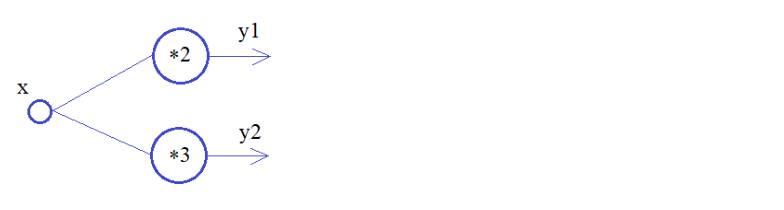

Здесь, фактически происходит суммирование градиентов от каждого выходного значения.

In [29]:
x = tf.Variable([1.0, 2.0])
 
with tf.GradientTape() as tape:
    y = tf.reduce_sum([2.0, 3.0] * x ** 2)
 
df = tape.gradient(y, x)
print(df, end = '\n\n')

# обратная ситуация

tf.Tensor([ 4. 12.], shape=(2,), dtype=float32)



Здесь аргумент является векторным, а выходная функция скаляром.